# IDS - Self-Organizing maps

In [35]:
# This is the visualization and implementation part of the IDS, using SOM 

In [36]:
import ids_utils, ids_metrics

In [37]:
import numpy as np
from minisom import MiniSom
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

In [38]:
def print_som_metrics(metrics):
    print('False alarm rate: {}%'.format(metrics.get_false_alarm_rate()*100))
    print('Detection rate: {}%'.format(metrics.get_detection_rate()*100))
    print("Acc: {}".format(metrics.get_accuracy()))
    print("TN: {}".format(metrics.tn))
    print("TP: {}".format(metrics.tp))
    print("FN: {}".format(metrics.fn))
    print("FP: {}".format(metrics.fp))
    print("Total instances: {}".format(metrics.size))
    print("Correctly classified: {}".format(metrics.hits))
    
def get_keys_sum(d, keys):
    s = 0
    for k in keys:
        s += d[k]
    return s

def get_malicious_or_not(d):
    mal_keys = list(filter(lambda k: k != 'normal.', d.keys()))
    mal_sum = get_keys_sum(d, mal_keys)
    normal_sum = 0
    if 'normal.' in d.keys():
        normal_sum = d['normal.']
    if mal_sum == 0 or normal_sum / mal_sum > 0.5:
        return 'normal.'
    else:
        return 'malicious.'
    

def decide_if_neurons_malicious(winner_cols):
    res = []
    for i in range(len(winner_cols)):
        res.append([])
        for j in range(len(winner_cols[i])):
            d = winner_cols[i][j]
            if len(d) == 0:
                res[i].append('normal.')
            else:
                key = max(d, key=d.get)
                res[i].append(get_malicious_or_not(d))
    return res
                

# Analysis of the dataset

In [39]:
df = ids_utils.load_ids_df('./data/kddcup.data_10_percent_corrected.csv')

In [40]:
len(df.columns)

42

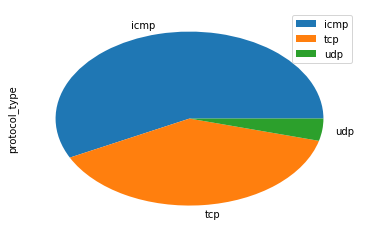

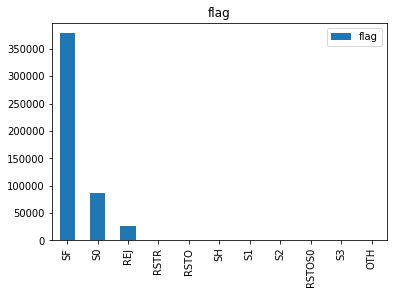

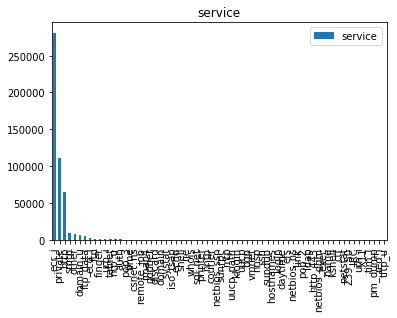

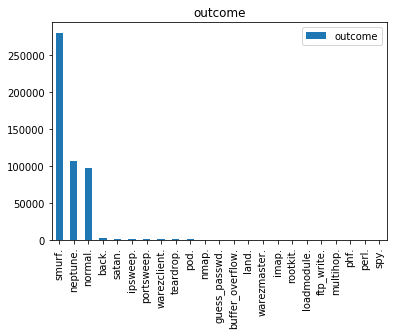

In [41]:
protocol_df = pd.DataFrame(df['protocol_type']).apply(pd.value_counts)
protocol_df.plot.pie(subplots=True)
plt.show()

plt.figure(figsize=(20,20))
pd.DataFrame(df['flag']).apply(pd.value_counts).plot.bar(subplots=True)
plt.show()

plt.figure(figsize=(20,20))
pd.DataFrame(df['service']).apply(pd.value_counts).plot.bar(subplots=True)
plt.show()

plt.figure(figsize=(20,20))
pd.DataFrame(df['outcome']).apply(pd.value_counts).plot.bar(subplots=True)
plt.show()

In [42]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494020.000000,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.0,494020.0,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,47.979400,3.025616e+03,8.685232e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.286347,292.907133,0.176687,0.176609,0.057434,0.057719,0.791547,0.020982,0.028997,232.471230,188.666034,0.753779,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.747185,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,0.010551,0.007793,2.012720,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147129,246.322733,0.380717,0.381017,0.231624,0.232147,0.388190,0.082206,0.142398,64.744665,106.040236,0.410781,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [44]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [45]:
numeric_df = df.select_dtypes(include=['float64', 'int64', 'uint8'])

In [46]:
numeric_df.dtypes

duration                         int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate                float64
same_srv_rate            

In [47]:
numeric_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494020.000000,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.0,494020.0,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,47.979400,3.025616e+03,8.685232e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,0.000111,0.000036,0.011352,0.001083,0.000109,0.001008,0.0,0.0,0.001387,332.286347,292.907133,0.176687,0.176609,0.057434,0.057719,0.791547,0.020982,0.028997,232.471230,188.666034,0.753779,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.747185,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,0.010551,0.007793,2.012720,0.096416,0.011020,0.036482,0.0,0.0,0.037211,213.147129,246.322733,0.380717,0.381017,0.231624,0.232147,0.388190,0.082206,0.142398,64.744665,106.040236,0.410781,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,117.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,510.000000,510.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,511.000000,511.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training by not eliminating categorical data

In [48]:
from sklearn.model_selection import train_test_split

In [18]:
df = ids_utils.load_ids_df('./data/kddcup.data_10_percent_corrected.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64', 'uint8'])
x = ids_utils.df_to_tf_matrix(numeric_df)
y = df['outcome'].as_matrix()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42)

In [22]:
som = MiniSom(20, 20, len(numeric_df.columns), sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
print("Training...")
som.train_random(x_train, 10000) # trains the SOM with 100 iterations
print("...ready!")

Training...
...ready!


In [23]:
list_train_data = ids_utils.append_label_column(x_train, pd.DataFrame(y_train), 0)
print('Mapping winners to matrix...')
%time winners_per_node = ids_utils.map_winner_neurons(som, list_train_data)

malicious_neurons = decide_if_neurons_malicious(winners_per_node)

C:\Users\cristi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Mapping winners to matrix...
Wall time: 6min 27s


In [34]:
malicious_neurons

[['malicious.',
  'malicious.',
  'normal.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'normal.',
  'malicious.',
  'malicious.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'normal.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.'],
 ['malicious.',
  'normal.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'malicious.',
  'normal.',
  'malicious.',
  'malicious.',
  'normal.',
  'malicious.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.'],
 ['normal.',
  'normal.',
  'normal.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'normal.',
  'normal.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.',
  'malicious.'],
 ['normal.',
  'normal.',
  'normal.',
  'normal.',
  'normal.',
  'malicious.',
  'malicious.',
  'malici

In [30]:
print("Computing metrics...")
list_test_data = ids_utils.append_label_column(x_test, pd.DataFrame(y_test), 0)
metrics = ids_metrics.test_som_and_get_stats(som, malicious_neurons, list_test_data)


Computing metrics...


C:\Users\cristi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [31]:
print_som_metrics(metrics)

False alarm rate: 0.567542607673579%
Detection rate: 99.43245739232643%
Acc: 0.9940758133948693
TN: 14447
TP: 59217
FN: 338
FP: 101
Total instances: 74103
Correctly classified: 73664


## Test data performance

In [32]:
testdf = ids_utils.load_ids_df('./data/test_data.csv')
print(np.shape(testdf))
testdf.head()

(311028, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
3,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [33]:
test_data = ids_utils.df_to_tf_matrix(testdf.select_dtypes(include=['float64', 'int64', 'uint8']))
test_data_with_labels = ids_utils.append_label_column(test_data, testdf)

#print('Running SOM on the test data...')
#%time winners = ids_utils.map_winner_neurons(som, test_data_with_labels)
#test_mal_neurons = decide_if_neurons_malicious(winners)

print('Getting metrics for test data...')
%time test_metrics = ids_metrics.test_som_and_get_stats(som, malicious_neurons, test_data_with_labels)
print_som_metrics(test_metrics)

C:\Users\cristi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Getting metrics for test data...
Wall time: 5min 9s
False alarm rate: 10.406650801003051%
Detection rate: 89.59334919899695%
Acc: 0.914898337127204
TN: 60185
TP: 224374
FN: 26062
FP: 407
Total instances: 311028
Correctly classified: 284559
